# APIs

Do a little scraping or API-calling of your own. Pick a new website and see what you can get out of it. Expect that you'll run into bugs and blind alleys.

Formally, your goal is to write a scraper that will:

- Return specific pieces of information (rather than just downloading a whole page)

- Iterate over multiple pages/queries

- Save the data to your computer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scrapy
from scrapy.crawler import CrawlerProcess

class CraigslistSpider(scrapy.Spider):
    name = "CL"
    start_urls = ['https://sfbay.craigslist.org/d/apts-housing-for-rent/search/apa']

    # Identifying the information we want from the query response and extracting it using xpath.
    def parse(self, response):
        for item in response.xpath('//li[@class="result-row"]'):
            yield {
                'price': item.xpath('*/span[@class="result-price"]/text()').extract_first(),
                'post_date': item.xpath('*/time[@class="result-date"]/text()').extract_first(),
                'title': item.xpath('*/a[@class="result-title hdrlnk"]/text()').extract_first(),
                'neighborhood': item.xpath('*/span[@class="result-meta"]/span[@class="result-hood"]/text()').extract_first(),
                'housing': item.xpath('*/span[@class="result-meta"]/span[@class="housing"]/text()').extract_first()
            }
        
        # Get the URL of the next page.
        next_page = response.xpath('//span[@class="buttons"]/a[@class="button next"]/@href').extract_first()
        
        # Recursively calling the spider to process the next ten entries, if they exist.
        if next_page is not None:
            next_page = '{}{}'.format(self.start_urls[0], next_page)
            yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'CL.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 3
})
                                         
# Starting the crawler with our spider.
process.crawl(CraigslistSpider)
process.start()
print('First 100 listings extracted!')

First 100 listings extracted!


In [3]:
house_listings = pd.read_json('CL.json', orient='records')
print(house_listings.shape)
print(house_listings.tail())

(360, 5)
                                               housing  \
355  \n                    1br -\n                 ...   
356      \n                    2br -\n                   
357  \n                    2br -\n                 ...   
358                                               None   
359  \n                    2br -\n                 ...   

                         neighborhood post_date  price  \
355    (oakland lake merritt / grand)    Jun 25  $2045   
356                (mission district)    Jun 25  $3475   
357             (albany / el cerrito)    Jun 25  $2775   
358                       (hollister)    Jun 25   None   
359   (fremont / union city / newark)    Jun 25  $2786   

                                                 title  
355  Large One BR/BA Across From Whole Foods HWFs G...  
356  Updated Romeo Flat-Quaint Street-W/D in Unit-O...  
357  Upper Level 2 BD/1 BA Albany Apt. with Garage ...  
358                      40 acres for rent / gardening  
359     

## Data Summary

Compute some statistical summaries and/or visualizations that give you some new insights into your topic. 

In [4]:
house_listings['housing'] = house_listings['housing'].str.strip()
house_listings['housing'] = house_listings['housing'].str.replace('\n', '')

house_listings['neighborhood'] = house_listings['neighborhood'].str.replace('(', '')
house_listings['neighborhood'] = house_listings['neighborhood'].str.replace(')', '')
house_listings['neighborhood'] = house_listings['neighborhood'].str.strip()

house_listings['price'] = house_listings['price'].str.replace('$', '')
house_listings['price'] = pd.to_numeric(house_listings['price'], errors='coerce')
house_listings.head(15)

,housing,neighborhood,post_date,price,title
0,2br - 1100ft,mountain view,Jun 25,3195.0,"Modern kitchen, 2 bedroom 2 bath apt, Mountain..."
1,2br - 1225ft,petaluma,Jun 25,2650.0,2 Bd/1BA 1225 sq.ft In-Law Unit Utilities Incl...
2,2br - 1225ft,petaluma,Jun 25,2650.0,"Petaluma 2 Bedroom, All Util Incl, great Wests..."
3,1br - 1600ft,healdsburg / windsor,Jun 25,1600.0,Cloverdale - 1 Bedroom Spacious Open Loft Styl...
4,3br - 1831ft,dublin / pleasanton / livermore,Jun 25,3800.0,Beautiful updated 3bd/2ba 1831sqft home
5,3br - 1359ft,mill valley,Jun 25,4500.0,"Stunning Views, Water Access, and Renovated"
6,2br - 984ft,santa clara,Jun 25,2800.0,"Walk to Safeway, CVS,Park,Library, Near Apple,..."
7,1br - 661ft,None,Jun 25,1965.0,"❄ Petaluma Apartment Living, Laundry Facilitie..."
8,3br -,visitacion valley,Jun 25,3450.0,New 3BR 2BA flat- Vis Valley
9,1br - 640ft,fremont / union city / newark,Jun 25,2195.0,"Perfect Fremont Location, w/ lots of Shopping ..."


In [5]:
def get_num_bedrooms(x):
    if x == None:
        return None
    elif 'ft' in x[0]:
        return None
    else:
        return x[0]

def get_num_sq_ft(x):
    if x == None:
        return None
    elif len(x) == 1 and 'ft' in x[0]:
        return x[0].replace('ft', '')
    elif len(x) == 1 and 'ft' not in x[0]:
        return None
    else:
        return x[1].replace('ft', '')

house_listings['num_bedrooms'] = house_listings['housing'].str.split('br -').apply(get_num_bedrooms)
house_listings['num_sq_ft'] = house_listings['housing'].str.split('br -').apply(get_num_sq_ft)

house_listings['num_bedrooms'] = pd.to_numeric(house_listings['num_bedrooms'])
house_listings['num_sq_ft'] = pd.to_numeric(house_listings['num_sq_ft'])
house_listings.head(15)

,housing,neighborhood,post_date,price,title,num_bedrooms,num_sq_ft
0,2br - 1100ft,mountain view,Jun 25,3195.0,"Modern kitchen, 2 bedroom 2 bath apt, Mountain...",2.0,1100.0
1,2br - 1225ft,petaluma,Jun 25,2650.0,2 Bd/1BA 1225 sq.ft In-Law Unit Utilities Incl...,2.0,1225.0
2,2br - 1225ft,petaluma,Jun 25,2650.0,"Petaluma 2 Bedroom, All Util Incl, great Wests...",2.0,1225.0
3,1br - 1600ft,healdsburg / windsor,Jun 25,1600.0,Cloverdale - 1 Bedroom Spacious Open Loft Styl...,1.0,1600.0
4,3br - 1831ft,dublin / pleasanton / livermore,Jun 25,3800.0,Beautiful updated 3bd/2ba 1831sqft home,3.0,1831.0
5,3br - 1359ft,mill valley,Jun 25,4500.0,"Stunning Views, Water Access, and Renovated",3.0,1359.0
6,2br - 984ft,santa clara,Jun 25,2800.0,"Walk to Safeway, CVS,Park,Library, Near Apple,...",2.0,984.0
7,1br - 661ft,None,Jun 25,1965.0,"❄ Petaluma Apartment Living, Laundry Facilitie...",1.0,661.0
8,3br -,visitacion valley,Jun 25,3450.0,New 3BR 2BA flat- Vis Valley,3.0,NaN
9,1br - 640ft,fremont / union city / newark,Jun 25,2195.0,"Perfect Fremont Location, w/ lots of Shopping ...",1.0,640.0


In [7]:
sf_areas = ['Dogpatch', 'sunset / parkside', 'alamo square / nopa', 'downtown / civic / van ness', 'ingleside / SFSU / CCSF', 'lower pac hts', 'hayes valley', 
       'lower nob hill', 'nob hill', 'cole valley / ashbury hts', 'inner sunset / UCSF', 'inner richmond',
       'castro / upper market', 'SOMA / south beach', 'sfbay', 'visitacion valley', 'marina / cow hollow', 'russian hill',
       'twin peaks / diamond hts', 'pacific heights', 'laurel hts / presidio', 'north beach / telegraph hill',
       'USF / panhandle', 'south san francisco', 'portola district', 'noe valley', 'mission district', 'richmond / seacliff', 'daly city']

north_of_bay_areas = ['healdsburg / windsor', 'sebastopol', 'greenbrae', 'santa rosa', 'larkspur', 'petaluma', 'tiburon / belvedere', 'mill valley', 'Near Downtown Napa, CA']

south_of_bay_areas = ['campbell', 'aptos', 'hollister', 'santa cruz', 'morgan hill', 'watsonville', 'gilroy', 'los gatos', 'santa clara', 'willow glen / cambrian', 
                      'milpitas', 'cupertino', 'sunnyvale', 'san jose south', 'san jose west', 'san jose east', 'san jose downtown', 'san jose north']

east_of_bay_areas = ['Crockett', 'richmond / point / annex', 'LAKE OF THE PINES', 'brentwood / oakley', 'danville / san ramon', 'Pittsburg, CA', 
                     'pittsburg / antioch', 'lafayette / orinda / moraga', 'vallejo / benicia', 'concord / pleasant hill / martinez', 'hayward / castro valley', 
                     'emeryville', 'fremont / union city / newark', 'oakland piedmont / montclair', 'oakland east', 'West Oakland', 'oakland hills / mills', 
                     'dublin / pleasanton / livermore', 'berkeley north / hills', 'Downtown Oakland', 'oakland lake merritt / grand', 'albany / el cerrito', 
                     'walnut creek', 'North Oakland', 'Emeryville', 'East Oakland', 'Berkeley']

peninsula_areas = ['san mateo', 'San Gregorio', 'mountain view', 'woodside', 'palo alto', 'foster city', 'belmont', 'redwood city', 'millbrae']

other = [None, 'California', '11843 Apple Grove Ln']

In [10]:
def categorize_by_region(hood):
    if hood in sf_areas:
        return 'SF'
    elif hood in north_of_bay_areas:
        return 'North of Bay'
    elif hood in south_of_bay_areas:
        return 'South of Bay'
    elif hood in east_of_bay_areas:
        return 'East of Bay'
    elif hood in peninsula_areas:
        return 'Peninsula'
    else:
        return 'Other'

In [12]:
df = house_listings.copy()
df['region'] = df['neighborhood'].apply(categorize_by_region)
df['region'].value_counts()

SF              145
East of Bay      88
South of Bay     74
Peninsula        29
North of Bay     16
Other             8
Name: region, dtype: int64

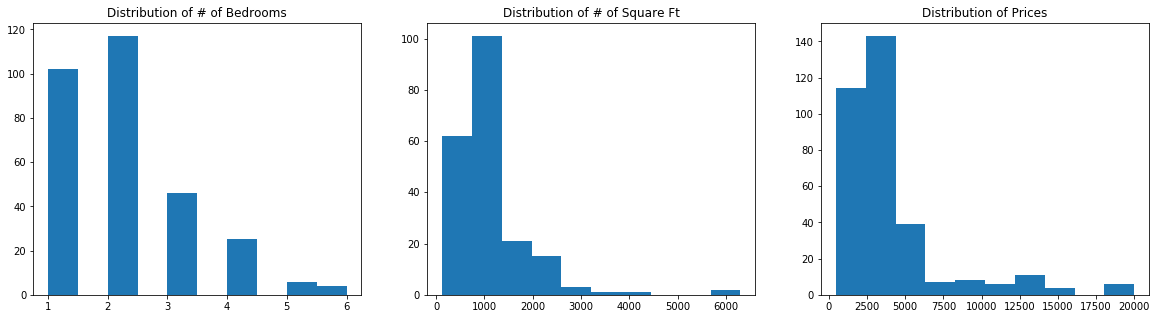

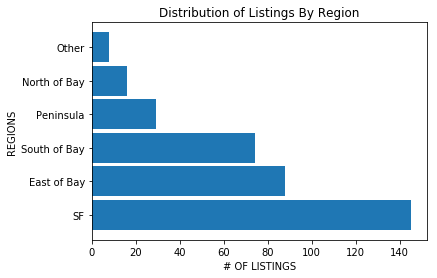

In [21]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.title('Distribution of # of Bedrooms')
plt.hist(df.dropna(subset=['num_bedrooms'])['num_bedrooms'])

plt.subplot(1, 3, 2)
plt.title('Distribution of # of Square Ft')
plt.hist(df.dropna(subset=['num_sq_ft'])['num_sq_ft'])

plt.subplot(1, 3, 3)
plt.title('Distribution of Prices')
plt.hist(df.dropna(subset=['price'])['price'])

# REGIONS

x = list(df.region.value_counts().index)
y = list(df.region.value_counts().values)

fig, ax = plt.subplots()    
width = 0.9
ind = np.arange(len(y))

ax.barh(ind, y, width)
ax.set_yticks(ind)
ax.set_yticklabels(x)

plt.title('Distribution of Listings By Region')
plt.xlabel('# OF LISTINGS')
plt.ylabel('REGIONS')

plt.show()

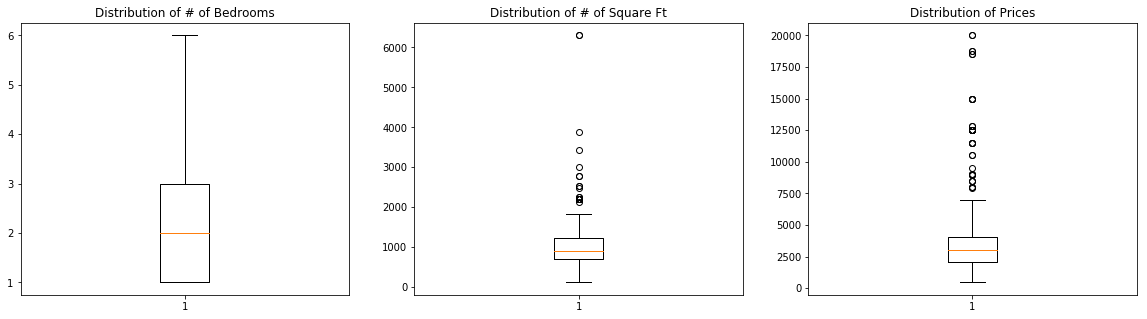

In [23]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.title('Distribution of # of Bedrooms')
plt.boxplot(df.dropna(subset=['num_bedrooms'])['num_bedrooms'])

plt.subplot(1, 3, 2)
plt.title('Distribution of # of Square Ft')
plt.boxplot(df.dropna(subset=['num_sq_ft'])['num_sq_ft'])

plt.subplot(1, 3, 3)
plt.title('Distribution of Prices')
plt.boxplot(df.dropna(subset=['price'])['price'])

plt.show()